In [39]:
### Dependencies ----------------------------------------------------------------
import pandas as pd # used for working with data sets


###COMBINE ALL .CSVS INTO ONE
file_path = r"..\data\combined.csv"


data = pd.read_csv(file_path)

# Slovník číselníků
num_dict = {
    'Prague-outskirts': 1,
    'Prague-center': 2,
    'Prague': 3
}

# Nový sloupec 'neighb_num' v DataFrame
data['neighb_num'] = data['neighbourhood_cleansed'].map(num_dict)

data.head()


,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,...,review_scores_rating,instant_bookable,host_since_bins,bathrooms_num,bathrooms_shared_bool,year,month,avg_price,date,neighb_num
0,4,1,1,1,0,1,0,Prague-center,Entire home/apt,3,...,5.000000,0,1,1.5,0,2023,6,1396.000000,2023-06-01,2
1,4,1,1,0,1,1,1,Prague-center,Entire home/apt,2,...,4.790000,0,1,1.0,0,2023,6,1645.571429,2023-06-01,2
2,1,0,1,0,0,0,1,Prague-outskirts,Private room,2,...,4.676121,0,1,2.0,0,2023,6,1000.000000,2023-06-01,1
3,2,1,1,0,0,1,1,Prague-center,Entire home/apt,6,...,4.620000,1,1,1.0,0,2023,6,2625.714286,2023-06-01,2
4,4,1,1,1,1,1,1,Prague-center,Entire home/apt,6,...,4.890000,1,1,1.5,0,2023,6,4927.142857,2023-06-01,2


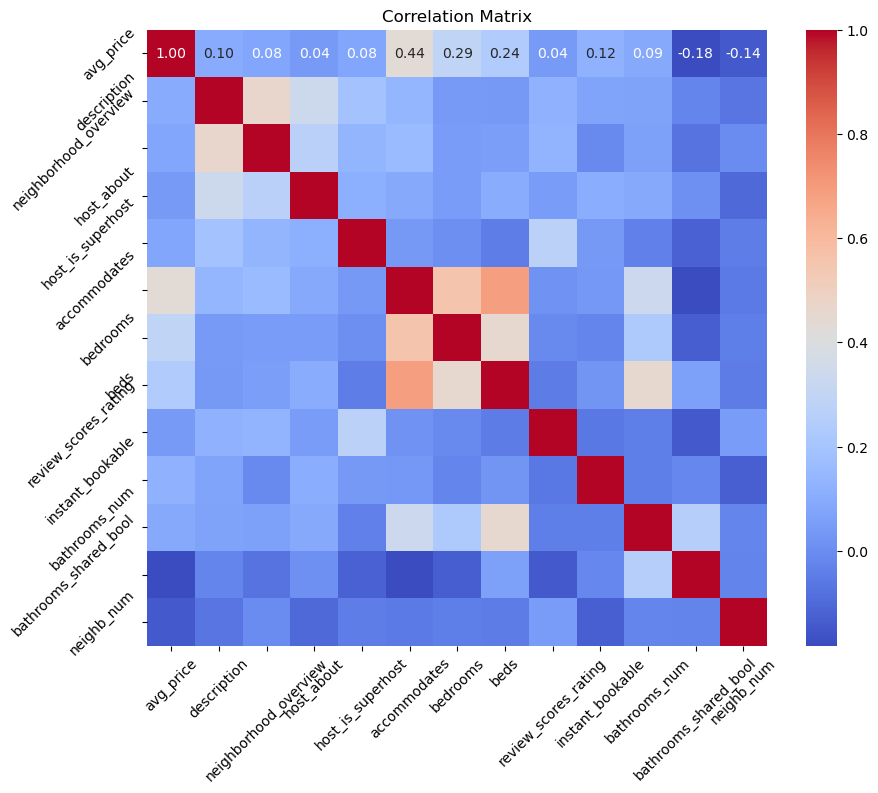

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = ['avg_price','description', 'neighborhood_overview', 'host_about', 'host_is_superhost',
                   'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'instant_bookable',
                   'bathrooms_num', 'bathrooms_shared_bool', 'neighb_num']  

selected_data = data[selected_columns]

correlation_matrix = selected_data.corr(method='pearson')

# Nastavení velikosti obrázku
plt.figure(figsize=(10, 8))

# Vytvoření heatmapy
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Nastavení popisků os
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Zobrazení grafu
plt.show()


In [40]:
# vytvoření dummy proměnných pro regrese

# One-Hot Encoding pro weathercode
neighbourhood_dummies = pd.get_dummies(data['neighbourhood_cleansed'], prefix='neighb-')
room_dummies = pd.get_dummies(data['room_type'], prefix='room-')


# Přidání zakódovaných sloupců zpět do dat
data = pd.concat([data, neighbourhood_dummies], axis=1)
data = pd.concat([data, room_dummies], axis=1)

data.head()

,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,...,avg_price,date,neighb_num,neighb-_Prague,neighb-_Prague-center,neighb-_Prague-outskirts,room-_Entire home/apt,room-_Hotel room,room-_Private room,room-_Shared room
0,4,1,1,1,0,1,0,Prague-center,Entire home/apt,3,...,1396.000000,2023-06-01,2,False,True,False,True,False,False,False
1,4,1,1,0,1,1,1,Prague-center,Entire home/apt,2,...,1645.571429,2023-06-01,2,False,True,False,True,False,False,False
2,1,0,1,0,0,0,1,Prague-outskirts,Private room,2,...,1000.000000,2023-06-01,1,False,False,True,False,False,True,False
3,2,1,1,0,0,1,1,Prague-center,Entire home/apt,6,...,2625.714286,2023-06-01,2,False,True,False,True,False,False,False
4,4,1,1,1,1,1,1,Prague-center,Entire home/apt,6,...,4927.142857,2023-06-01,2,False,True,False,True,False,False,False


## Matice 2 with dummies

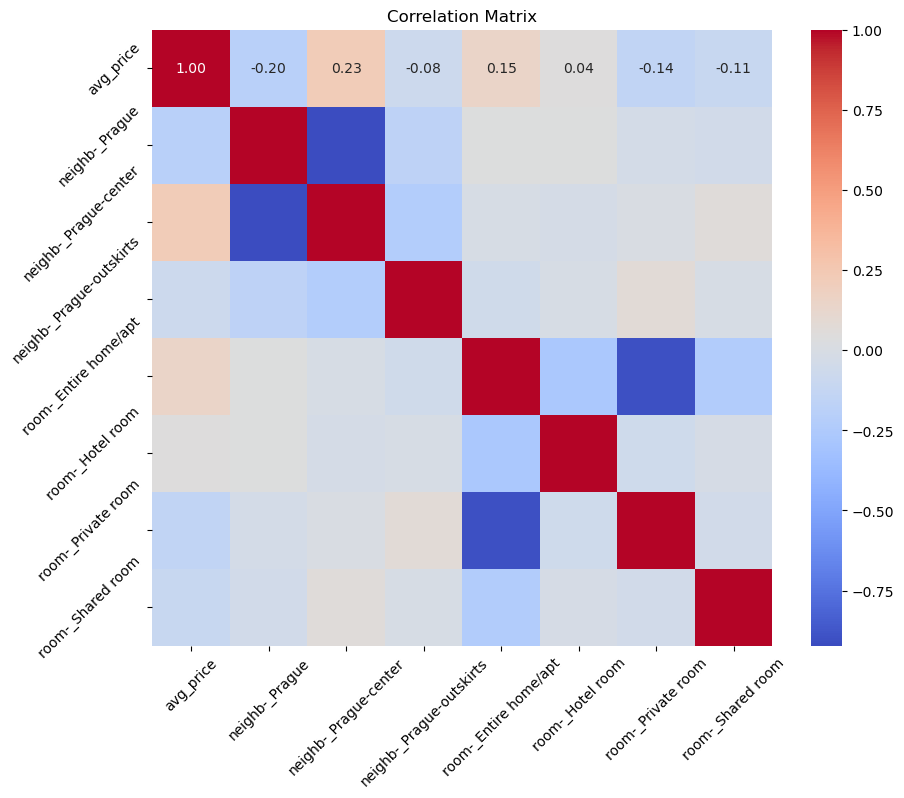

In [38]:
data = data[['avg_price','neighb-_Prague','neighb-_Prague-center', 'neighb-_Prague-outskirts', 'room-_Entire home/apt', 'room-_Hotel room', 'room-_Private room','room-_Shared room']]

correlation_matrix = data.corr(method='pearson')

# Nastavení velikosti obrázku
plt.figure(figsize=(10, 8))

# Vytvoření heatmapy
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Nastavení popisků os
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Zobrazení grafu
plt.show()

In [44]:
## dělba na datasety, ale nějak se to jebe, je to potřeba polatid, aby to fakt bylo správně podle toho data, chyba je nejspíš v tom postupu toho train test splitu...

#from sklearn.model_selection import train_test_split

# # Převedení sloupce 'date' na datový typ datetime
# data['date'] = pd.to_datetime(data['date'])

# Seřazení dat podle data
data_sorted = data.sort_values(by='date', ascending=True)

print(data_sorted['date'])

# # Rozdělení dat na trénovací, validační a testovací množiny
# train_data, test_valid_data = train_test_split(data_sorted, test_size=0.4, shuffle=False)
# valid_data, test_data = train_test_split(test_valid_data, test_size=0.5, shuffle=False)

# # Uložení jednotlivých množin do DataFrame
# train_df = pd.DataFrame(train_data)
# valid_df = pd.DataFrame(valid_data)
# test_df = pd.DataFrame(test_data)

total_rows = len(data_sorted)
train_idx = int(total_rows * 0.6)
valid_idx = int(total_rows * 0.8)

X_train = data_sorted.iloc[:train_idx].drop(['avg_price','neighbourhood_cleansed','room_type','date','neighb_num'], axis=1)
y_train = data_sorted.iloc[:train_idx]['avg_price']

X_valid = data_sorted.iloc[train_idx:valid_idx].drop(['avg_price','neighbourhood_cleansed','room_type','date', 'neighb_num'], axis=1)
y_valid = data_sorted.iloc[train_idx:valid_idx]['avg_price']

X_test = data_sorted.iloc[valid_idx:].drop(['avg_price','neighbourhood_cleansed','room_type','date', 'neighb_num'], axis=1)
y_test = data_sorted.iloc[valid_idx:]['avg_price']




0         2023-06-01
5502      2023-06-01
5501      2023-06-01
5500      2023-06-01
5499      2023-06-01
             ...    
131127    2024-09-01
131126    2024-09-01
131125    2024-09-01
131123    2024-09-01
136733    2024-09-01
Name: date, Length: 136734, dtype: object


In [5]:
num_rows_train = len(X_train)
num_rows_valid = len(X_valid)
num_rows_test = len(X_test)

print(f"Number of rows in training data: {num_rows_train}")
print(f"Number of rows in validation data: {num_rows_valid}")
print(f"Number of rows in testing data: {num_rows_test}")

Number of rows in training data: 82040
Number of rows in validation data: 27347
Number of rows in testing data: 27347


In [43]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 82040 entries, 0 to 78472
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   description               82040 non-null  int64  
 1   neighborhood_overview     82040 non-null  int64  
 2   host_since                82040 non-null  int64  
 3   host_about                82040 non-null  int64  
 4   host_is_superhost         82040 non-null  int64  
 5   host_has_profile_pic      82040 non-null  int64  
 6   host_identity_verified    82040 non-null  int64  
 7   accommodates              82040 non-null  int64  
 8   bedrooms                  82040 non-null  float64
 9   beds                      82040 non-null  float64
 10  number_of_reviews         82040 non-null  int64  
 11  review_scores_rating      82040 non-null  float64
 12  instant_bookable          82040 non-null  int64  
 13  host_since_bins           82040 non-null  int64  
 14  bathrooms_n

In [ ]:
# Kontrola výsledků
print("Trénovací data:")
print(X_train['date'].head())
print("\nValidační data:")
print(X_valid['date'].head())
print("\nTestovací data:")
print(X_test['date'].head())


In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Vytvoření a trénování lineární regrese
model = LinearRegression()
model.fit(X_train, y_train)

# Predikce na testovací množině
y_pred = model.predict(X_valid)

# Výpočet Mean Squared Error
mse = mean_squared_error(y_valid, y_pred)
coefficients_train_rel = model.coef_
intercept_train_rel = model.intercept_


# Výpis výsledků
print("Intercept:", intercept_train_rel )
print("Coefficients:", coefficients_train_rel)
print("Mean Squared Error:", mse)  

rmse = mse**(1/2)
print("Root Mean Squared Error:",rmse)


Intercept: -607745.2186680156
Coefficients: [   4.89690464   23.36730865  -89.7421327   -57.64718597  195.41236979
  416.04071536 -914.68688955  403.98708537  209.57142853  -79.91242856
   -2.39575471  205.37567089  245.12528755  -89.7421327    61.96341477
 -506.51706985  300.44005375   39.32977769   95.12995083 -290.79397343
  676.71789769 -385.92392426   55.38772624  637.49499567  107.54928326
 -800.43200517]
Mean Squared Error: 5779533.722057783
Root Mean Squared Error: 2404.066081050557


Intercept je číslo, kde je X = 0 -> kdy ta pomyslná přímka té regrese protíná osu Y. Intercept se přičítá vždycky k tý hodnotě a podle toho, jaký hodnoty dosahuje proměnná každého z těch koeficientů, tak se to tím buď násobí nebo ne. Ty koeficienty jsou za sebou seřazené tak, jak do té regrese vstupovaly ty jednotlivé parametry -> z leva do prava v tabulce všechno kromě dropnutých sloupečků. Odchylka je šílená.

In [14]:
from sklearn.linear_model import Lasso

# Vytvoření modelu Lasso regrese
alpha = 1  # Parametr regularizace, můžete experimentovat s různými hodnotami
lasso = Lasso(alpha=alpha)

# Naučení modelu na trénovacích datech
lasso.fit(X_train, y_train)

# Predikce na testovacích datech
Y_pred = lasso.predict(X_valid)

# Interpretace koeficientů
intercept_bal_rel_lasso = lasso.intercept_
coefficients_bal_rel_lasso = lasso.coef_
mse = mean_squared_error(y_valid, Y_pred)
rmse = mse**(1/2)


# Výpis výsledků
print("Intercept:", intercept_bal_rel_lasso)
print("Coefficients:", coefficients_bal_rel_lasso)
print("Mean Squared Error:", mse)  
print("Root Mean Squared Error:", rmse)


Intercept: -561416.3004142605
Coefficients: [ 5.84053844e+00  1.90026876e+01 -4.56677027e-02 -5.28066104e+01
  1.89720730e+02  3.53690250e+02 -8.85748130e+02  4.06852913e+02
  2.09534315e+02 -8.31502394e+01 -2.39512240e+00  2.01583594e+02
  2.39792240e+02 -1.25699488e+02  5.60023988e+01 -4.89873512e+02
  2.77585153e+02  3.68041078e+01  0.00000000e+00 -0.00000000e+00
  8.69300665e+02 -2.59984435e+02 -1.26657172e+01  5.13129695e+02
  2.36176658e+01 -7.73722203e+02]
Mean Squared Error: 5791151.979472644
Root Mean Squared Error: 2406.4812443633637


## Random Forest

In [45]:
### Dependencies
import pandas as pd #data frames and other stuff
import matplotlib.pyplot as plt #basic graphs
import pickle
import shap #for SHAP values
import time #for timing calculation

# Usefull functions
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay #plot_partial_dependence

# Used models
from sklearn.ensemble import RandomForestRegressor



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [46]:
#%reset -f

SEED = 500


# Instantiate RandomForestRegressor 'rf' 1000 estimators
forest_model_0 = RandomForestRegressor(n_estimators=1000,
                                   min_samples_split=0.05,
                                   max_features = 8,
                                   random_state=SEED)


In [47]:
# Fit 'rf' to the training set
forest_model_0.fit(X_train, y_train.values.ravel()) #values.ravel() flattened array expected by RandomForestRegressor
# Predict the test set labels 'y_pred'
y_pred_0 = forest_model_0.predict(X_test)
# Evaluate the test set RMSE
rmse_test_0 = mean_squared_error(y_test, y_pred_0, squared=False)
print(rmse_test_0)

2508.0542961216106


In [48]:
###########################################
###Exhaustive grid optimization using CV###
###########################################

# Create the  grid
hyper_grid = {'n_estimators': [3000,5000],
               'max_features': [4,8,9,12],
               'min_samples_split': [10, 20]}

#reinstantiate RandomForestRegressor regressor with empty parameter set
forest_model_cv = RandomForestRegressor()

# Instantiate the GridSearchCV with forest_model_cv  as estimator
grid_search = GridSearchCV(estimator = forest_model_cv, param_grid = hyper_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)



In [49]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
#best parameters
print(grid_search.best_params_)
#best estimator
forest_model_opt= grid_search.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'max_features': 9, 'min_samples_split': 10, 'n_estimators': 5000}


In [50]:
# Predict the test set labels 'y_pred'
y_pred_cv = forest_model_opt.predict(X_test)
rmse_test_cv = mean_squared_error(y_test, y_pred_cv, squared=False)
print(rmse_test_cv)
print(rmse_test_0)

1705.9447493208627
2508.0542961216106


In [51]:
import pickle

# Assuming 'forest_model_opt' is your best estimator from the grid search
with open('optimized_forest_model.pkl', 'wb') as file:
    pickle.dump(forest_model_opt, file)

print("Optimized model saved successfully!")

Optimized model saved successfully!


## XGBOOST

In [52]:
### Dependencies
import xgboost as xgb #pip3 install xgboost
import pickle
import numpy as np

# Usefull functions
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [53]:
gbm0 = xgb.XGBRegressor(n_estimators = 50, learning_rate = 0.1, objective='reg:squarederror',seed = SEED)

#using dictionary with HP 
#prms = {"n_estimators":50, "learning_rate": 0.1}
#gbm0 = xgb.XGBRegressor(**prms, objective='reg:squarederror',seed = SEED)

#Fit XGBoost with SciKit
gbm0.fit(X_train, y_train)

#Alternativelly, use directly XGBoost, xgb.train(dtrain = train_dmatrix, params = params) but Dmatrix needs to be created

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
# Predict the test set labels 'y_pred0'
y_pred0 = gbm0.predict(X_test)

# Evaluate the test set RMSE
rmse_test0 = mean_squared_error(y_test, y_pred0, squared=False)
print(rmse_test0)

2297.307445435988


#### grid

In [56]:
########################
####Grid optimization###
########################

#setup params grid
param_grid = {'learning_rate': [0.01,0.1,0.5], #alias eta, Step size shrinkage used in update to prevents overfitting.  
    'n_estimators': [20, 50, 100],
    'subsample': [0.5, 0.8, 1], #Subsample ratio of the training instances
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.5, 1] #colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    }

#instantiate XGBRegressor 
gbm = xgb.XGBRegressor(seed=SEED, objective='reg:squarederror')
grid_mse = GridSearchCV(estimator=gbm,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1)
#fit  GridSearchCV 
grid_mse.fit(X_train, y_train)

print("Best parameters found: ",grid_mse.best_params_) #best_params_
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_))) #best_score_
# tady to bylo na trénovaích datech nás zajímá na test datech
#extract the estimator best_estimator_ 
gbm_ins = grid_mse.best_estimator_ #best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1}
Lowest RMSE found:  1298.2240131756396


In [57]:
# Predict the test set labels 'y_pred'
y_pred = gbm_ins.predict(X_test)

# Evaluate the test set RMSE
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_test)

1664.755258119156


In [58]:

with open('optimized_xgboost.pkl', 'wb') as file:
    pickle.dump(gbm_ins, file)

print("Optimized model saved successfully!")

Optimized model saved successfully!
